#seq model 2


In [ ]:
import numpy as np
import pandas as pd 
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Dense, Flatten, Dropout, SeparableConv1D
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join
from tensorflow.keras.utils import plot_model,to_categorical
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/MyDrive/'CMPT 340 Project'/audio_and_txt_files

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1e1OTACsf9h9Mi5uoqIsDyb3h904F6VDk/CMPT 340 Project/audio_and_txt_files


In [ ]:
diagnosis_df = pd.read_csv('/content/gdrive/MyDrive/CMPT 340 Project/patient_diagnosis.csv', names=['Patient number', 'Diagnosis'])
df_no_diagnosis = pd.read_csv('/content/gdrive/MyDrive/CMPT 340 Project/demographic_info.txt', names = ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'], delimiter = ' ')
df =  df_no_diagnosis.join(diagnosis_df.set_index('Patient number'), on = 'Patient number', how = 'left')


In [ ]:
root = '/content/gdrive/MyDrive/CMPT 340 Project/audio_and_txt_files'

In [ ]:
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s] 

In [ ]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [ ]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,160,1b3,Ar,mc,AKGC417L
0,160,1b4,Al,mc,AKGC417L
0,160,1b3,Lr,mc,AKGC417L
0,160,1b4,Tc,mc,AKGC417L
0,160,2b4,Ar,mc,AKGC417L


In [ ]:
class Diagnosis():
    def __init__ (self, id, diagnosis, image_path):
        self.id = id
        self.diagnosis = diagnosis 
        self.image_path = image_path

In [ ]:
def get_wav_files():
    audio_path = '/content/gdrive/MyDrive/CMPT 340 Project/audio_and_txt_files/'
    files = [f for f in listdir(audio_path) if isfile(join(audio_path, f))]  #Gets all files in dir
    wav_files = [f for f in files if f.endswith('.wav')]  # Gets wav files 
    wav_files = sorted(wav_files)
    return wav_files, audio_path

# could be our implementation

In [ ]:
def diagnosis_data():
    diagnosis = pd.read_csv('/content/gdrive/MyDrive/CMPT 340 Project/patient_diagnosis.csv')
  
    wav_files, audio_path = get_wav_files()
    diag_dict = { 101 : "URTI"}  
    diagnosis_list = []
  
    for index , row in diagnosis.iterrows():
        diag_dict[row[0]] = row[1]     

    c = 0
    for f in wav_files:
        print(f)
        print(f[:3])
        diagnosis_list.append(Diagnosis(c, diag_dict[float(f[:3])], audio_path+f))  
        c+=1  

    return diagnosis_list

In [ ]:
def audio_features(filename): 
    sound, sample_rate = librosa.load(filename)
    stft = np.abs(librosa.stft(sound))  

    mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40),axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate),axis=1)
    mel = np.mean(librosa.feature.melspectrogram(sound, sr=sample_rate),axis=1)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate),axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate),axis=1)
    
    concat = np.concatenate((mfccs,chroma,mel,contrast,tonnetz))
    print(concat.size)
    return concat

In [ ]:
def data_points():
    labels = []
    images = []

    to_hot_one = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}

    #count = 0
    for f in diagnosis_data():
        #print(count)
        labels.append(to_hot_one[f.diagnosis]) 
        images.append(audio_features(f.image_path))
        print(f)
        #count+=1

    return np.array(labels), np.array(images)

In [ ]:
path = '/content/gdrive/MyDrive/CMPT 340 Project/filename_differences.txt'

diff = pd.read_csv(path, sep=" ", header=None, names=['file_names'])
diff.head(5)

,file_names
0,'101_1b1_Al_sc_AKGC417L'
1,'101_1b1_Pr_sc_AKGC417L'
2,'102_1b1_Ar_sc_AKGC417L'
3,'105_1b1_Tc_sc_LittC2SE'
4,'108_1b1_Al_sc_LittC2SE'


In [ ]:
df =  diff.join(diagnosis_df,how = 'left')
df.head(15)


,file_names,Patient number,Diagnosis
0,'101_1b1_Al_sc_AKGC417L',101,URTI
1,'101_1b1_Pr_sc_AKGC417L',102,Healthy
2,'102_1b1_Ar_sc_AKGC417L',103,Asthma
3,'105_1b1_Tc_sc_LittC2SE',104,COPD
4,'108_1b1_Al_sc_LittC2SE',105,URTI
5,'111_1b2_Tc_sc_LittC2SE',106,COPD
6,'111_1b3_Tc_sc_LittC2SE',107,COPD
7,'115_1b1_Ar_sc_LittC2SE',108,LRTI
8,'116_1b2_Pl_sc_LittC2SE',109,COPD
9,'116_1b2_Tc_sc_LittC2SE',110,COPD


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=193
  n_fft, y.shape[-1]


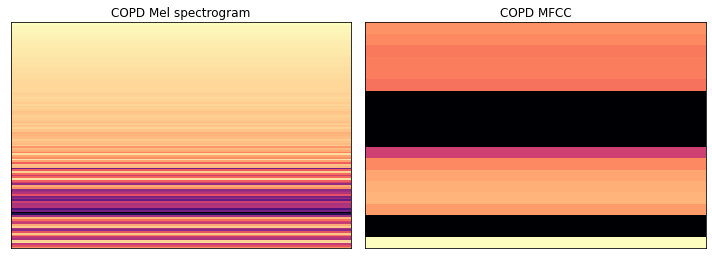

In [ ]:
x1 = audio_features('/content/gdrive/MyDrive/CMPT 340 Project/audio_and_txt_files/106_2b1_Pl_mc_LittC2SE.wav')
S1 = librosa.feature.melspectrogram(x1)

plt.figure(figsize=(10, 7))
plt.subplot(2,2,1)
librosa.display.specshow(librosa.power_to_db(S1, ref=np.max))
plt.title('COPD Mel spectrogram')
plt.tight_layout()

T1 = librosa.feature.mfcc(x1)
plt.subplot(2,2,2)
librosa.display.specshow(librosa.power_to_db(T1, ref=np.max))
plt.title('COPD MFCC')
plt.tight_layout()

In [ ]:
def preprocessing(labels, images):    

  # Remove Asthma and LRTI
    images = np.delete(images, np.where((labels == 7) | (labels == 6))[0], axis=0) 
    labels = np.delete(labels, np.where((labels == 7) | (labels == 6))[0], axis=0)      
    
  # Split data
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=10)

  # Hot one encode the labels
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)  

  # Format new data
    y_train = np.reshape(y_train, (y_train.shape[0], 6))
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 6))
    X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1],  1))

    return X_train, X_test, y_train, y_test

In [ ]:
labels, images = data_points()

In [ ]:
X_train, X_test, y_train, y_test = preprocessing(labels, images)

In [ ]:
model = Sequential()
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(193, 1)))

model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(SeparableConv1D(256, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(SeparableConv1D(256, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2)) 

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(512, activation='relu'))   
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=70, batch_size=200, verbose=1)

Epoch 1/70
4/4 [==============================] - 4s 622ms/step - loss: 1.2920 - accuracy: 0.6357 - val_loss: 0.5304 - val_accuracy: 0.8967
Epoch 2/70
4/4 [==============================] - 2s 539ms/step - loss: 0.7126 - accuracy: 0.8568 - val_loss: 0.4823 - val_accuracy: 0.8967
Epoch 3/70
4/4 [==============================] - 2s 549ms/step - loss: 0.7219 - accuracy: 0.8568 - val_loss: 0.4267 - val_accuracy: 0.8967
Epoch 4/70
4/4 [==============================] - 2s 548ms/step - loss: 0.5897 - accuracy: 0.8568 - val_loss: 0.4585 - val_accuracy: 0.8967
Epoch 5/70
4/4 [==============================] - 2s 539ms/step - loss: 0.5728 - accuracy: 0.8568 - val_loss: 0.4380 - val_accuracy: 0.8967
Epoch 6/70
4/4 [==============================] - 2s 538ms/step - loss: 0.5478 - accuracy: 0.8568 - val_loss: 0.4171 - val_accuracy: 0.8967
Epoch 7/70
4/4 [==============================] - 2s 533ms/step - loss: 0.5479 - accuracy: 0.8568 - val_loss: 0.4110 - val_accuracy: 0.8967
Epoch 8/70
4/4 [====

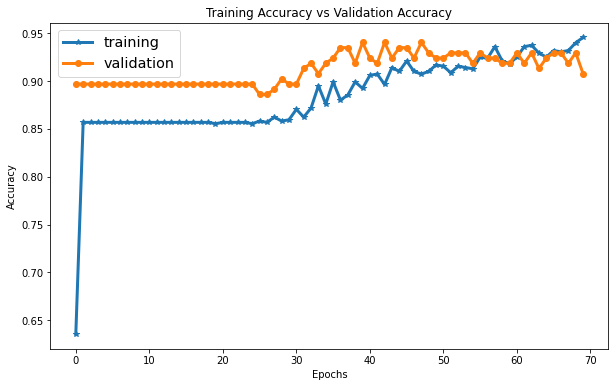

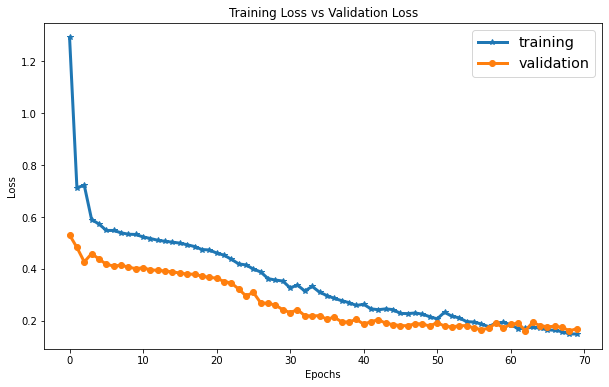

In [ ]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize = 'x-large')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.show()
visualize_training(history)

                precision    recall  f1-score   support

          COPD       0.99      0.97      0.98       165
       Healthy       0.43      0.43      0.43         7
          URTI       0.00      0.00      0.00         4
Bronchiectasis       1.00      0.25      0.40         4
     Pneumoina       0.38      1.00      0.55         3
 Bronchiolitis       0.00      0.00      0.00         1

      accuracy                           0.91       184
     macro avg       0.47      0.44      0.39       184
  weighted avg       0.93      0.91      0.91       184



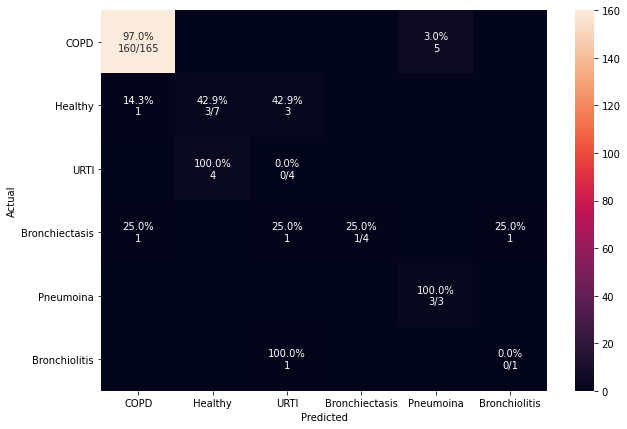

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis"]

preds = model.predict(X_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')

In [ ]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 29ms/step - loss: 0.1687 - accuracy: 0.9076


[0.168715700507164, 0.907608687877655]